# Analyze Time Efficiency of Load Balancing Algorithms

Theoretically, EPLB's time complexity should be similar to that of BLDM's. 
- EPLB: $T = L(g \log g + \frac{P}{N} \log\left(\frac{P}{N}\right) + \frac{P E}{N}) = L(E \log E + E^2)$
- BLDM: $T = L(E \log E + \frac{E^2}{G})$


    - G: number of GPUs(in our case, it's 8)
    - g: number of expert groups in EPLB(in our case, it's 1)
    - P: number of physical experts/replicas(in our case, it's 256)
    - E: number of logical experts(in our case, it's 256)
    - N: number of nodes(in our case it's 1)
    - L: number of MoE layers(in our case, it's 58)

But when executed on my laptop, the runtime is very different.

I noticed that in EPLB, all the operations are conducted using torch.tensor api, while in BLDM they are done through Python List api, maybe that's the reason for runtime discrepency.


I replaced `list operations` with corresponding `torch.tensor operations` in BLDM, and found that it is these such operations that caused this execution delay.

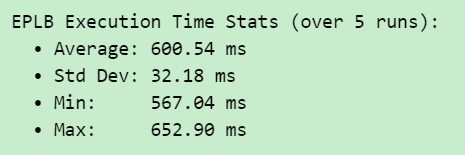 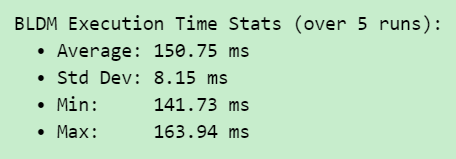

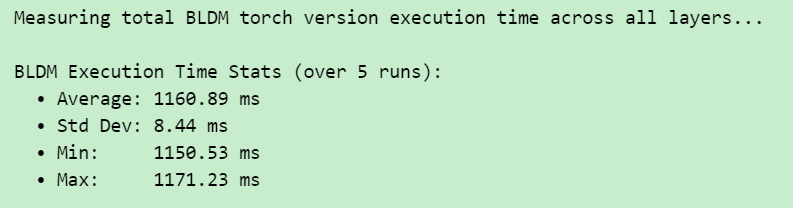

## Common Functions

In [10]:
import os
import re
import json
import statistics
from typing import Callable, Tuple, List, Optional

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import numpy as np

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


def calculate_gpu_loads(original_weights: torch.Tensor, num_gpus: int):
    num_layers, num_experts = original_weights.shape
    experts_per_gpu = num_experts // num_gpus

    assert num_experts % num_gpus == 0, "Experts cannot be evenly divided among GPUs."

    gpu_loads = torch.zeros((num_layers, num_gpus), dtype=original_weights.dtype)

    for layer_idx in range(num_layers):
        for gpu_idx in range(num_gpus):
            start_idx = gpu_idx * experts_per_gpu
            end_idx = (gpu_idx + 1) * experts_per_gpu
            gpu_loads[layer_idx, gpu_idx] = original_weights[
                layer_idx, start_idx:end_idx
            ].sum()

    return gpu_loads


def save_gpu_loads_to_csv(
    gpu_loads: torch.Tensor, output_folder: str, file_name: str, num_gpus: int
):
    gpu_loads_df = pd.DataFrame(
        gpu_loads.numpy(),
        columns=[f"GPU{i}" for i in range(num_gpus)],
        index=list(range(gpu_loads.shape[0])),
    )
    csv_save_path = os.path.join(output_folder, file_name)
    gpu_loads_df.to_csv(csv_save_path)


def plot_gpu_loads_analysis(
    gpu_loads: torch.Tensor, heatmap_save_path: str, boxplot_save_path: str
):
    """
    Plot normalized heatmap and boxplot of GPU loads.

    Args:
        gpu_loads (torch.Tensor): Tensor of shape [58, 8] (layers x GPUs).
        heatmap_save_path (str): File path to save heatmap.
        boxplot_save_path (str): File path to save boxplot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Normalize the gpu loads per layer
    layer_sums = gpu_loads.sum(dim=1, keepdim=True)  # Sum across GPUs for each layer
    normalized_gpu_loads = gpu_loads / layer_sums  # Each row sums to 1

    # 1. Heatmap: Normalized Load per layer per GPU
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        normalized_gpu_loads.numpy(),
        cmap="Reds",
        annot=True,
        fmt=".2f",  # Show 2 decimal places for better precision
        linewidths=0.5,
        cbar_kws={"label": "Normalized Load"},
        yticklabels=list(range(gpu_loads.shape[0])),  # Layer IDs
        annot_kws={"size": 6},
    )
    plt.xlabel("GPU Index")
    plt.ylabel("Layer ID")
    plt.title("Normalized GPU Loads per Layer")
    plt.tight_layout()
    plt.savefig(heatmap_save_path)
    print(f"Normalized heatmap saved to: {heatmap_save_path}")
    plt.close()

    # 2. Boxplot: Distribution of normalized GPU loads across layers
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=normalized_gpu_loads.numpy())
    plt.axhline(
        y=1.0 / normalized_gpu_loads.shape[1], color="blue", linestyle="-"
    )  # Ideal line
    overall_std = normalized_gpu_loads.numpy().flatten().std()
    plt.annotate(
        xy=(0.98, 0.98),
        xycoords="axes fraction",
        text=f"Overall Std Dev: σ = {overall_std:.4f}",
        ha="right",
        va="top",
        fontsize=10,
        color="blue",
        bbox=dict(
            boxstyle="round,pad=0.3", edgecolor="gray", facecolor="white", alpha=0.7
        ),
    )
    plt.xlabel("GPU Index")
    plt.ylabel("Normalized Load")
    plt.title("GPU Load Distribution Across Layers (Normalized Boxplot)")
    plt.tight_layout()
    plt.savefig(boxplot_save_path)
    print(f"Normalized boxplot saved to: {boxplot_save_path}")
    plt.close()


def remap_weights(
    phy2log: torch.Tensor, original_weights: torch.Tensor
) -> torch.Tensor:
    """
    Remap the original logical expert weights according to the phy2log mapping.

    Args:
        phy2log (torch.Tensor): A tensor of shape [58, 256], where each value is a logical_expert_id.
        original_weights (torch.Tensor): A tensor of shape [58, 256], where the index is the logical_expert_id and the value is the corresponding weight.

    Returns:
        torch.Tensor: A new tensor of shape [58, 256], where each physical expert has its remapped weight.
    """
    num_layers, num_physical_experts = phy2log.shape
    new_weights = torch.zeros_like(phy2log, dtype=original_weights.dtype)

    for layer_idx in range(num_layers):
        # Get the mapping from physical experts to logical experts for this layer
        logical_ids = phy2log[layer_idx]  # Shape: [256]
        # Fetch the corresponding weights from original_weights using the logical expert IDs
        new_weights[layer_idx] = original_weights[layer_idx][logical_ids]

    return new_weights


def normalize_gpu_loads(gpu_loads: torch.Tensor) -> torch.Tensor:
    """
    Normalize GPU loads layer-wise so that each row sums to 1.
    """
    layer_sums = gpu_loads.sum(dim=1, keepdim=True)  # Sum across GPUs for each layer
    normalized_gpu_loads = gpu_loads / layer_sums
    return normalized_gpu_loads


def natural_sort_key(s: str) -> List:
    """Generate a natural sort key for strings.

    Args:
        s: Input string to be sorted

    Returns:
        A list that can be used for natural sorting
    """
    return [
        int(text) if text.isdigit() else text.lower() for text in re.split(r"(\d+)", s)
    ]


def load_csv_to_tensor(input_folder: str) -> Optional[torch.Tensor]:
    """Load CSV files from a folder and convert them to a tensor.

    Each CSV file represents one layer, and is converted to one row in the output tensor.

    Args:
        input_folder: Path to folder containing CSV files

    Returns:
        torch.Tensor of shape [num_layers, num_experts] or None if an error occurs
    """
    # Get all csv files and sort them naturally
    csv_files = sorted(
        [
            os.path.join(input_folder, f)
            for f in os.listdir(input_folder)
            if f.endswith(".csv")
        ],
        key=natural_sort_key,
    )
    num_layers = len(csv_files)

    if num_layers == 0:
        print(f"No CSV files found in {input_folder}")
        return None

    # Initialize a list to store rows
    rows = []

    for csv_file in csv_files:
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file, header=None)
            # Sum up all rows in the CSV file
            row_sums = df.sum(axis=0).values
            # Append to the list as a row
            rows.append(row_sums)
        except Exception as e:
            print(f"Error processing file {csv_file}: {e}")
            return None

    # Stack all rows into a single tensor of shape [num_layers, num_experts]
    return torch.tensor(np.array(rows), dtype=torch.float32)


def count_expert_moves(assignment: torch.Tensor) -> int:
    """input one-hot assignment"""
    nb_experts_per_gpu = assignment.shape[1] // assignment.shape[0]
    return sum(
        [
            sum(
                [
                    int(assignment[gpu][expert].item())
                    for expert in range(assignment.shape[1])
                    if (expert // nb_experts_per_gpu) != gpu
                ]
            )
            for gpu in range(assignment.shape[0])
        ]
    )


def get_naive_assignment(nb_gpus: int, nb_experts: int) -> torch.Tensor:
    """return vanilla one-hot assignment of experts to GPUs"""
    nb_experts_per_gpu = nb_experts // nb_gpus
    return torch.Tensor(
        [
            [
                (
                    1
                    if i < (j + 1) * nb_experts_per_gpu and i >= j * nb_experts_per_gpu
                    else 0
                )
                for i in range(nb_experts)
            ]
            for j in range(nb_gpus)
        ]
    ).long()


def get_readable_assignment(assignment: torch.Tensor) -> str:
    """return a readable string of the one-hot assignment"""
    assignment_str = ""
    for gpu in range(assignment.shape[0]):
        assignment_str += f"GPU {gpu}:"
        for expert, value in enumerate(assignment[gpu]):
            if value:
                assignment_str += f" {expert}"
        assignment_str += "\n"
    return assignment_str


def phy_to_assignment(
    phy2log: torch.Tensor, nb_gpus: int, nb_experts: int
) -> torch.Tensor:
    """
    convert phy2log to one-hot assignment, if assignment[0][32] = 1, then in this layer, logical_expert 32 is located on gpu0.
    """
    assert nb_experts % nb_gpus == 0, "Experts cannot be evenly divided among GPUs."
    return torch.sum(
        torch.nn.functional.one_hot(phy2log).view(nb_gpus, nb_experts // nb_gpus, -1),
        dim=1,
    )


def get_gpu_load(
    assignment: torch.Tensor,
    hotness: torch.Tensor,
):
    return torch.matmul(assignment.float(), hotness.float())


def adjust_hotness(hotness: torch.Tensor, assignment: torch.Tensor) -> torch.Tensor:
    """
    Args:
        - hotness: [E], total logical hotness
        - assignment: [G, E], 1 if logical expert is on GPU

    Returns:
        - adjusted_hotness: [E], hotness per replica (logical expert / replica count)
    """
    assignment = assignment.float()
    replica_count = assignment.sum(dim=0)  # [E]
    adjusted_hotness = hotness.float() / replica_count.clamp(min=1)
    return adjusted_hotness


def measure_execution_time(func: Callable[[], dict], warmup: int, repeat: int):
    for _ in range(warmup):
        func()

    times = []
    final_result = None
    for _ in range(repeat):
        start = time.perf_counter()
        final_result = func()
        end = time.perf_counter()
        times.append((end - start) * 1000)  # ms

    return {
        "result": final_result,
        "avg": statistics.mean(times),
        "std": statistics.stdev(times) if repeat > 1 else 0,
        "min": min(times),
        "max": max(times),
        "all_times": times,
    }


def minimize_moves(
    num_experts, num_gpus, hotness: torch.Tensor, assignments: torch.Tensor
) -> torch.Tensor:
    bins = torch.arange(
        0,
        int(torch.max(hotness).item() + 11),
        # int(0.5 * self.nb_experts),
        10,
    )
    digitized = torch.bucketize(hotness, bins, right=True)
    # Try sort approach rather than bin approach

    number_experts_per_gpu = num_experts // num_gpus
    binned = [
        torch.arange(num_experts)[digitized == i].tolist() for i in range(1, len(bins))
    ]
    assignment_indices = torch.arange(num_experts)[torch.argsort(assignments)]
    for i, expert in enumerate(assignments):
        gpu = i // number_experts_per_gpu
        # Nothing to change. The expert is on the original GPU
        if (
            gpu * number_experts_per_gpu <= expert
            and expert < (gpu + 1) * number_experts_per_gpu
        ):
            continue
        current_expert_bin = digitized[expert]
        experts_in_same_bin = binned[current_expert_bin - 1]
        for i, same_bin_expert in enumerate(experts_in_same_bin):
            # We found an expert with the same kind of hotness that belongs to the current GPU
            if (
                same_bin_expert != expert
                and gpu * number_experts_per_gpu <= same_bin_expert
                and same_bin_expert < (gpu + 1) * number_experts_per_gpu
            ):
                # We get the index of the original gpu
                # gpu_ind = np.where(assignments[:, same_bin_expert] == 1)[0]
                # assert len(gpu_ind) == 1
                # gpu_ind = gpu_ind[0]
                # if gpu_ind == gpu:
                # continue
                (
                    assignments[assignment_indices[expert]],
                    assignments[assignment_indices[same_bin_expert]],
                ) = (
                    assignments[assignment_indices[same_bin_expert]],
                    assignments[assignment_indices[expert]],
                )

                # We don't want this expert to be swapped again
                del experts_in_same_bin[i]

                break

    return assignments

## EPLB

### Source Code

In [20]:
from typing import Tuple

import torch

def balanced_packing(weight: torch.Tensor, num_packs: int) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Pack n weighted objects to m packs, such that each bin contains exactly n/m objects and the weights of all packs
    are as balanced as possible.

    Parameters:
        weight: [X, n], the weight of each item
        num_packs: number of packs
    
    Returns: 
        pack_index: [X, n], the pack index of each item
        rank_in_pack: [X, n], the rank of the item in the pack
    """
    num_layers, num_groups = weight.shape
    assert num_groups % num_packs == 0
    groups_per_pack = num_groups // num_packs

    if groups_per_pack == 1:
        pack_index = torch.arange(weight.size(-1), dtype=torch.int64, device=weight.device).expand(weight.shape)
        rank_in_pack = torch.zeros_like(weight, dtype=torch.int64)
        return pack_index, rank_in_pack

    indices = weight.float().sort(-1, descending=True).indices.cpu() # O(n log n)
    pack_index = torch.full_like(weight, fill_value=-1, dtype=torch.int64, device='cpu')
    rank_in_pack = torch.full_like(pack_index, fill_value=-1)
    for i in range(num_layers):
        pack_weights = [0] * num_packs
        pack_items = [0] * num_packs
        for group in indices[i]:
            pack = min((i for i in range(num_packs) if pack_items[i] < groups_per_pack), 
                       key=pack_weights.__getitem__)
            assert pack_items[pack] < groups_per_pack
            pack_index[i, group] = pack
            rank_in_pack[i, group] = pack_items[pack]
            pack_weights[pack] += weight[i, group]
            pack_items[pack] += 1
    return pack_index, rank_in_pack


def replicate_experts(weight: torch.Tensor, num_phy: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:

    """
    Replicate `num_log` experts to `num_phy` replicas, such that the maximum load of all replicas is minimized.

    Parameters:
        weight: [X, num_log]
        num_phy: total number of experts after replication
    
    Returns:
        phy2log: [X, num_phy], logical expert id of each physical expert
        rank: [X, num_phy], the replica rank
        logcnt: [X, num_log], number of replicas for each logical expert
    """
    n, num_log = weight.shape
    num_redundant = num_phy - num_log
    assert num_redundant >= 0
    device = weight.device
    phy2log = torch.arange(num_phy, dtype=torch.int64, device=device).repeat(n, 1)
    rank = torch.zeros(n, num_phy, dtype=torch.int64, device=device)
    logcnt = torch.ones(n, num_log, dtype=torch.int64, device=device)
    arangen = torch.arange(n, dtype=torch.int64, device=device)
    for i in range(num_log, num_phy):
        redundant_indices = (weight / logcnt).max(dim=-1).indices
        phy2log[:, i] = redundant_indices
        rank[:, i] = logcnt[arangen, redundant_indices]
        logcnt[arangen, redundant_indices] += 1
    return phy2log, rank, logcnt


def rebalance_experts_hierarchical(weight: torch.Tensor, num_physical_experts: int, 
                      num_groups: int, num_nodes: int, num_gpus: int):
    """
    Parameters:
        weight: [num_moe_layers, num_logical_experts]
        num_physical_experts: number of physical experts after replication
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns: 
        physical_to_logical_map: [num_moe_layers, num_physical_experts]
        logical_to_physical_map: [num_moe_layers, num_logical_experts, X]
        logical_count: [num_moe_layers, num_logical_experts]
    """
    num_layers, num_logical_experts = weight.shape
    assert num_logical_experts % num_groups == 0
    group_size = num_logical_experts // num_groups 
    assert num_groups % num_nodes == 0
    groups_per_node = num_groups // num_nodes
    assert num_gpus % num_nodes == 0
    assert num_physical_experts % num_gpus == 0
    phy_experts_per_gpu = num_physical_experts // num_gpus

    def inverse(perm: torch.Tensor) -> torch.Tensor:
        inv = torch.empty_like(perm)
        inv.scatter_(1, perm, torch.arange(perm.size(1), dtype=torch.int64, device=perm.device).expand(perm.shape))
        return inv

    # Step 1: pack groups to nodes
    tokens_per_group = weight.unflatten(-1, (num_groups, group_size)).sum(-1)
    group_pack_index, group_rank_in_pack = balanced_packing(tokens_per_group, num_nodes) 
    log2mlog = (((group_pack_index * groups_per_node + group_rank_in_pack) * group_size).unsqueeze(-1) + 
                torch.arange(group_size, dtype=torch.int64, device=group_pack_index.device)).flatten(-2)
    mlog2log = inverse(log2mlog)

    # Step 2: construct redundant experts within nodes
    # [num_layers * num_nodes, num_logical_experts // num_nodes]
    tokens_per_mlog = weight.gather(-1, mlog2log).view(-1, num_logical_experts // num_nodes)
    phy2mlog, phyrank, mlogcnt = replicate_experts(tokens_per_mlog, num_physical_experts // num_nodes)    

    # Step 3: pack physical_experts to GPUs
    # [num_layers * num_nodes, num_physical_experts // num_nodes]
    tokens_per_phy = (tokens_per_mlog / mlogcnt).gather(-1, phy2mlog)
    pack_index, rank_in_pack = balanced_packing(tokens_per_phy, num_gpus // num_nodes)
    phy2pphy = pack_index * phy_experts_per_gpu + rank_in_pack
    pphy2phy = inverse(phy2pphy)

    pphy2mlog = phy2mlog.gather(-1, pphy2phy) # [num_layers * num_nodes, num_log_per_nodes]
    pphy2mlog = (pphy2mlog.view(num_layers, num_nodes, -1) + 
                 torch.arange(0, num_logical_experts, num_logical_experts // num_nodes,
                              device=group_pack_index.device).view(1, -1, 1)).flatten(-2)
    pphy2log = mlog2log.gather(-1, pphy2mlog)
    pphyrank = phyrank.gather(-1, pphy2phy).view(num_layers, -1)
    logcnt = mlogcnt.view(num_layers, -1).gather(-1, log2mlog)
    return pphy2log, pphyrank, logcnt

def rebalance_experts(weight: torch.Tensor, num_replicas: int, num_groups: int,
                      num_nodes: int, num_gpus: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Entry point for expert-parallelism load balancer.

    Parameters:
        weight: [layers, num_logical_experts], the load statistics for all logical experts
        num_replicas: number of physical experts, must be a multiple of `num_gpus`
        num_groups: number of expert groups
        num_nodes: number of server nodes, where the intra-node network (e.g, NVLink) is faster
        num_gpus: number of GPUs, must be a multiple of `num_nodes`

    Returns: 
        physical_to_logical_map: [layers, num_replicas], the expert index of each replica
        logical_to_physical_map: [layers, num_logical_experts, X], the replica indices for each expert
        expert_count: [layers, num_logical_experts], number of physical replicas for each logical expert
    """
    num_layers, num_logical_experts = weight.shape
    weight = weight.float().cpu()
    if num_groups % num_nodes == 0:
        # use hierarchical load-balance policy
        phy2log, phyrank, logcnt = rebalance_experts_hierarchical(weight, num_replicas, 
                                                                  num_groups, num_nodes, num_gpus)
    else:
        # use global load-balance policy
        phy2log, phyrank, logcnt = rebalance_experts_hierarchical(weight, num_replicas, 1, 1, num_gpus)
    maxlogcnt = logcnt.max().item()
    log2phy: torch.Tensor = torch.full((num_layers, num_logical_experts, maxlogcnt), 
                                       -1, dtype=torch.int64, device=logcnt.device)
    log2phy.view(num_layers, -1).scatter_(-1, phy2log * maxlogcnt + phyrank, 
            torch.arange(num_replicas, dtype=torch.int64, device=log2phy.device).expand(num_layers, -1))
    return phy2log, log2phy, logcnt


### Python List Operation Version

In [4]:
from typing import List, Tuple


def balanced_packing_py(weight: List[List[float]], num_packs: int) -> Tuple[List[List[int]], List[List[int]]]:
    """
    Pure Python version of balanced packing.

    Args:
        weight: 2D list [num_layers][num_groups], group loads
        num_packs: number of bins (nodes or GPUs)

    Returns:
        pack_index: [num_layers][num_groups], index of pack for each group
        rank_in_pack: [num_layers][num_groups], position within the pack
    """
    num_layers = len(weight)
    num_groups = len(weight[0])
    groups_per_pack = num_groups // num_packs

    pack_index = [[-1] * num_groups for _ in range(num_layers)]
    rank_in_pack = [[-1] * num_groups for _ in range(num_layers)]

    for i in range(num_layers):
        indices = sorted(range(num_groups), key=lambda j: -weight[i][j])
        pack_weights = [0.0] * num_packs
        pack_counts = [0] * num_packs
        for group in indices:
            min_pack = min((p for p in range(num_packs) if pack_counts[p] < groups_per_pack),
                           key=lambda p: pack_weights[p])
            pack_index[i][group] = min_pack
            rank_in_pack[i][group] = pack_counts[min_pack]
            pack_weights[min_pack] += weight[i][group]
            pack_counts[min_pack] += 1
    return pack_index, rank_in_pack


def replicate_experts_py(weight: List[List[float]], num_phy: int) -> Tuple[List[List[int]], List[List[int]], List[List[int]]]:
    """
    Replicate logical experts to physical experts with minimal max load.
    """
    num_layers = len(weight)
    num_log = len(weight[0])
    num_redundant = num_phy - num_log

    phy2log = [[i if i < num_log else -1 for i in range(num_phy)] for _ in range(num_layers)]
    rank = [[0] * num_phy for _ in range(num_layers)]
    logcnt = [[1] * num_log for _ in range(num_layers)]

    for i in range(num_log, num_phy):
        for layer in range(num_layers):
            best = max(range(num_log), key=lambda j: weight[layer][j] / logcnt[layer][j])
            phy2log[layer][i] = best
            rank[layer][i] = logcnt[layer][best]
            logcnt[layer][best] += 1

    return phy2log, rank, logcnt


def inverse_mapping(mapping: List[List[int]]) -> List[List[int]]:
    """
    Invert a 2D permutation matrix
    """
    inv = [[-1] * len(row) for row in mapping]
    for i in range(len(mapping)):
        for j, val in enumerate(mapping[i]):
            inv[i][val] = j
    return inv


def rebalance_experts_py(weight: List[List[float]], num_replicas: int, num_groups: int, num_nodes: int, num_gpus: int):
    """
    Fully Python list-based EPLB.

    Returns:
        phy2log: [layers][num_replicas]
        log2phy: [layers][num_log][max_cnt]
        logcnt: [layers][num_log]
    """
    num_layers = len(weight)
    num_log = len(weight[0])
    group_size = num_log // num_groups
    groups_per_node = num_groups // num_nodes
    phy_per_gpu = num_replicas // num_gpus

    # Step 1: pack groups to nodes
    tokens_per_group = [[sum(weight[i][j*group_size + k] for k in range(group_size)) for j in range(num_groups)] for i in range(num_layers)]
    group_pack_index, group_rank = balanced_packing_py(tokens_per_group, num_nodes)

    log2mlog = [[(group_pack_index[i][g] * groups_per_node + group_rank[i][g]) * group_size + k
                 for g in range(num_groups) for k in range(group_size)] for i in range(num_layers)]
    mlog2log = inverse_mapping(log2mlog)

    # Step 2: replicate within node
    tokens_per_mlog = [[weight[i][mlog2log[i][j]] for j in range(num_log)] for i in range(num_layers)]
    phy2mlog, phyrank, logcnt = replicate_experts_py(tokens_per_mlog, num_replicas)

    # Step 3: pack physical experts to GPUs
    # reuse balanced_packing on approximated phy loads
    tokens_per_phy = [[tokens_per_mlog[i][phy2mlog[i][j]] / logcnt[i][phy2mlog[i][j]] for j in range(num_replicas)]
                      for i in range(num_layers)]
    pack_index, rank_in_pack = balanced_packing_py(tokens_per_phy, num_gpus)
    phy2pphy = [[pack_index[i][j] * phy_per_gpu + rank_in_pack[i][j] for j in range(num_replicas)] for i in range(num_layers)]
    pphy2phy = inverse_mapping(phy2pphy)

    pphy2mlog = [[phy2mlog[i][pphy2phy[i][j]] for j in range(num_replicas)] for i in range(num_layers)]
    offset = [n * (num_log // num_nodes) for n in range(num_nodes)]
    pphy2mlog = [[pphy2mlog[i][j] + offset[j // (num_replicas // num_nodes)] for j in range(num_replicas)] for i in range(num_layers)]
    pphy2log = [[mlog2log[i][pphy2mlog[i][j]] for j in range(num_replicas)] for i in range(num_layers)]
    pphyrank = [[phyrank[i][pphy2phy[i][j]] for j in range(num_replicas)] for i in range(num_layers)]

    max_cnt = max(max(row) for row in logcnt)
    log2phy = [[[-1]*max_cnt for _ in range(num_log)] for _ in range(num_layers)]
    for i in range(num_layers):
        for j in range(num_replicas):
            log = pphy2log[i][j]
            rank = pphyrank[i][j]
            log2phy[i][log][rank] = j

    return pphy2log, log2phy, logcnt


### Execute EPLB

In [23]:
input_folder = r"/home/bingxche/log/deepseek-v3_tp8_mixtral_dataset_5000_prompts_vanilla/moe_token_dist"
output_folder = os.path.join(input_folder, "eplb")
os.makedirs(output_folder, exist_ok=True)
weights = load_csv_to_tensor(input_folder).to("cpu")
if weights is None:
    raise ValueError(f"Failed to load weights from {input_folder}")

eplb_config = {
    "num_replicas": 256,  # Number of physical experts
    "num_groups": 1,
    "num_nodes": 1,
    "num_gpus": 8,
}


def run_eplb_all_layers():
    phy2log, log2phy, logcnt = rebalance_experts(
        weight=weights,
        num_replicas=eplb_config["num_replicas"],
        num_groups=eplb_config["num_groups"],
        num_nodes=eplb_config["num_nodes"],
        num_gpus=eplb_config["num_gpus"],
    )
    return {"phy2log": phy2log, "log2phy": log2phy, "logcnt": logcnt}


print("\nMeasuring total EPLB execution time across all layers...")


repeat_runs = 5
warmup_runs = 2
eplb_stats = measure_execution_time(
    run_eplb_all_layers, warmup=warmup_runs, repeat=repeat_runs
)

print(f"\nEPLB Execution Time Stats (over {repeat_runs} runs):")
print(f"  • Average: {eplb_stats['avg']:.2f} ms")
print(f"  • Std Dev: {eplb_stats['std']:.2f} ms")
print(f"  • Min:     {eplb_stats['min']:.2f} ms")
print(f"  • Max:     {eplb_stats['max']:.2f} ms")


Measuring total EPLB execution time across all layers...

EPLB Execution Time Stats (over 5 runs):
  • Average: 389.10 ms
  • Std Dev: 0.56 ms
  • Min:     388.51 ms
  • Max:     389.78 ms


### Execute EPLB-py version

In [32]:
input_folder = r"/home/bingxche/log/deepseek-v3_tp8_mixtral_dataset_5000_prompts_vanilla/moe_token_dist"
output_folder = os.path.join(input_folder, "eplb")
os.makedirs(output_folder, exist_ok=True)
weights = load_csv_to_tensor(input_folder)
if weights is None:
    raise ValueError(f"Failed to load weights from {input_folder}")

eplb_config = {
    "num_replicas": 256,  # Number of physical experts
    "num_groups": 1,
    "num_nodes": 1,
    "num_gpus": 8,
}


def run_eplb_all_layers():
    phy2log, log2phy, logcnt = rebalance_experts_py(
        weight=weights,
        num_replicas=eplb_config["num_replicas"],
        num_groups=eplb_config["num_groups"],
        num_nodes=eplb_config["num_nodes"],
        num_gpus=eplb_config["num_gpus"],
    )
    return {"phy2log": phy2log, "log2phy": log2phy, "logcnt": logcnt}


print("\nMeasuring total EPLB execution time across all layers...")


repeat_runs = 5
warmup_runs = 2
eplb_stats = measure_execution_time(
    run_eplb_all_layers, warmup=warmup_runs, repeat=repeat_runs
)

print(f"\nEPLB Execution Time Stats (over {repeat_runs} runs):")
print(f"  • Average: {eplb_stats['avg']:.2f} ms")
print(f"  • Std Dev: {eplb_stats['std']:.2f} ms")
print(f"  • Min:     {eplb_stats['min']:.2f} ms")
print(f"  • Max:     {eplb_stats['max']:.2f} ms")


Measuring total EPLB execution time across all layers...

EPLB Execution Time Stats (over 5 runs):
  • Average: 577.98 ms
  • Std Dev: 33.86 ms
  • Min:     552.81 ms
  • Max:     615.33 ms


## BLDM

### Source Code

In [33]:
from typing import List, Tuple, Union

import torch
from torch import Tensor
import os
import pandas as pd


class BLDMBalancer:
    def __init__(
        self,
        number_of_gpus: int,
        number_of_experts: int,
        **kwargs,
    ):
        self.nb_gpus = number_of_gpus
        self.number_of_experts = number_of_experts
        self.device = torch.device("cpu")

    # Section 2: https://link.springer.com/chapter/10.1007/3-540-36494-3_51
    @staticmethod
    def argsort(seq):
        # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
        return sorted(range(len(seq)), key=seq.__getitem__)

    def get_graph_name(self) -> str:
        return "BLDM"

    @staticmethod
    def __algo(buckets: List[List[List[Tuple[int, int]]]]):
        d_diff = []
        sums = []

        for partition in buckets:
            local_sums = [sum(elem[0] for elem in subset) for subset in partition]
            sorted_sums = BLDMBalancer.argsort(local_sums)
            sums.append(sorted_sums)
            d_diff.append(local_sums[sorted_sums[-1]] - local_sums[sorted_sums[0]])
        sorted_d_diff = BLDMBalancer.argsort(d_diff)
        p1_ind = sorted_d_diff[-1]
        p2_ind = sorted_d_diff[-2]
        p1 = buckets[p1_ind]
        p2 = buckets[p2_ind]
        new_partition = [
            p1[sums[p1_ind][j]] + p2[sums[p2_ind][len(sums[p2_ind]) - j - 1]]
            for j in range(len(sums[p1_ind]))
        ]

        del buckets[p1_ind]
        if p1_ind < p2_ind:
            p2_ind = p2_ind - 1
        del buckets[p2_ind]
        buckets.append(new_partition)

    def balance(self, hotness: Tensor) -> Union[Tensor, None]:
        # From wikipedia description
        buckets: List[List[List[Tuple[int, int]]]] = []
        hotnesses = hotness.tolist()
        hotnesses = [(hotness, expert) for expert, hotness in enumerate(hotnesses)]
        hotnesses.sort(key=lambda x: x[0])  # O(n log n)
        assert len(hotnesses) % self.nb_gpus == 0

        # Initialization phase
        m = len(hotnesses) // self.nb_gpus
        k = 0
        for i in range(m):  # O(n)
            local_bucket = []
            for j in range(self.nb_gpus):
                local_bucket.append([hotnesses[k]])
                k = k + 1
            buckets.append(local_bucket)

        # Applying algo
        while len(buckets) > 1:
            BLDMBalancer.__algo(buckets)

        # Retrieving solution
        solution = buckets[0]
        self.solution = solution
        # if self.minimize_moves:
        # return LoadBalancer.minimize_moves(hotness, np.array(assignment))
        sequential_solution = []
        for partition in self.solution:
            for _, expert in partition:
                sequential_solution.append(expert)

        self.solution = torch.Tensor(sequential_solution)
        return self.solution

### Torch.tensor API version

In [13]:
from typing import List, Tuple, Union

import torch
from torch import Tensor
import os
import pandas as pd


class BLDMBalancerTorch:
    def __init__(
        self,
        number_of_gpus: int,
        number_of_experts: int,
        **kwargs,
    ):
        self.nb_gpus = number_of_gpus
        self.number_of_experts = number_of_experts
        self.device = torch.device("cpu")

    # Section 2: https://link.springer.com/chapter/10.1007/3-540-36494-3_51
    @staticmethod
    def argsort(seq):
        # http://stackoverflow.com/questions/3071415/efficient-method-to-calculate-the-rank-vector-of-a-list-in-python
        return sorted(range(len(seq)), key=seq.__getitem__)

    def get_graph_name(self) -> str:
        return "BLDM"

    @staticmethod
    def __algo(buckets: List[List[List[Tuple[int, int]]]]):
        d_diff = []
        sums = []

        for partition in buckets:
            local_sums = torch.tensor(
                [sum(elem[0] for elem in subset) for subset in partition],
                dtype=torch.float32,
            )
            sorted_sums = torch.argsort(local_sums)
            sums.append(sorted_sums)
            d_diff.append(local_sums[sorted_sums[-1]] - local_sums[sorted_sums[0]])
        sorted_d_diff = torch.argsort(torch.stack(d_diff))
        p1_ind = sorted_d_diff[-1].item()
        p2_ind = sorted_d_diff[-2].item()
        p1 = buckets[p1_ind]
        p2 = buckets[p2_ind]
        new_partition = [
            p1[sums[p1_ind][j].item()]
            + p2[sums[p2_ind][len(sums[p2_ind]) - j - 1].item()]
            for j in range(len(sums[p1_ind]))
        ]

        del buckets[p1_ind]
        if p1_ind < p2_ind:
            p2_ind -= 1
        del buckets[p2_ind]
        buckets.append(new_partition)

    def balance(self, hotness: Tensor) -> Union[Tensor, None]:
        # From wikipedia description
        buckets: List[List[List[Tuple[int, int]]]] = []
        sorted_vals, sorted_idx = torch.sort(hotness)  # 已是升序
        hotnesses = list(
            zip(sorted_vals.tolist(), sorted_idx.tolist())  # 仅用于后面构造 buckets
        )
        assert len(hotnesses) % self.nb_gpus == 0

        # Initialization phase
        m = len(hotnesses) // self.nb_gpus
        k = 0
        for i in range(m):  # O(n)
            local_bucket = []
            for j in range(self.nb_gpus):
                local_bucket.append([hotnesses[k]])
                k = k + 1
            buckets.append(local_bucket)

        # Applying algo
        while len(buckets) > 1:
            BLDMBalancerTorch.__algo(buckets)

        # Retrieving solution
        solution = buckets[0]
        self.solution = solution
        # if self.minimize_moves:
        # return LoadBalancer.minimize_moves(hotness, np.array(assignment))
        sequential_solution = []
        for partition in self.solution:
            for _, expert in partition:
                sequential_solution.append(expert)

        self.solution = torch.Tensor(sequential_solution)
        return self.solution

### new bldm torch

In [29]:
import torch
from torch import Tensor
from typing import Union


class BLDMBalancerPureTensor:
    def __init__(self, number_of_gpus: int, number_of_experts: int, **kwargs):
        self.nb_gpus = number_of_gpus
        self.number_of_experts = number_of_experts
        self.device = torch.device("cpu")

    def get_graph_name(self) -> str:
        return "BLDM_Tensor"

    def __merge_partitions(self, buckets: Tensor) -> Tensor:
        """
        buckets: Tensor of shape [n_partitions, nb_gpus, group_size, 2]
        Returns: merged buckets with one less partition
        """
        # Sum hotness per GPU per partition -> [n_partitions, nb_gpus]
        hotness_sums = buckets[:, :, :, 0].sum(dim=2)
        partition_max = hotness_sums.max(dim=1).values
        partition_min = hotness_sums.min(dim=1).values
        imbalance = partition_max - partition_min  # [n_partitions]

        top2 = torch.topk(imbalance, 2).indices
        p1_idx, p2_idx = top2[0].item(), top2[1].item()

        p1 = buckets[p1_idx]  # [nb_gpus, g1, 2]
        p2 = buckets[p2_idx]  # [nb_gpus, g2, 2]

        # 计算 GPU 负载排序（每个 partition 内部）
        s1 = p1[:, :, 0].sum(dim=1)  # [nb_gpus]
        s2 = p2[:, :, 0].sum(dim=1)
        s1_sort = torch.argsort(s1)
        s2_sort = torch.argsort(s2, descending=True)

        # 合并两个分区
        merged = torch.cat(
            [p1[s1_sort[i]] + p2[s2_sort[i]] for i in range(self.nb_gpus)], dim=0
        ).view(self.nb_gpus, -1, 2)  # [nb_gpus, new_group_size, 2]

        # 构造新的 buckets
        mask = torch.ones(buckets.shape[0], dtype=torch.bool)
        mask[[p1_idx, p2_idx]] = False
        new_buckets = buckets[mask]
        new_buckets = torch.cat([new_buckets, merged.unsqueeze(0)], dim=0)
        return new_buckets

    def balance(self, hotness: Tensor) -> Tensor:
        hotness = hotness.to(self.device)
        num_experts = hotness.shape[0]
        assert num_experts % self.nb_gpus == 0
        m = num_experts // self.nb_gpus

        # 1. 初始化：排序 + 构造初始 buckets
        sorted_vals, sorted_idx = torch.sort(hotness)
        expert_pairs = torch.stack([sorted_vals, sorted_idx], dim=1)  # [E, 2]
        buckets = expert_pairs.view(m, self.nb_gpus, 1, 2)  # [m, nb_gpus, 1, 2]

        # 2. 合并直到只剩一个分区
        while buckets.shape[0] > 1:
            buckets = self.__merge_partitions(buckets)

        # 3. 展平最终结果
        final_assignment = buckets[0][:, :, 1].flatten().long()  # [nb_gpus * final_group_size]
        self.solution = final_assignment
        return final_assignment


### Execute BLDM

In [34]:
# config
input_folder = r"/home/bingxche/log/deepseek-v3_tp8_mixtral_dataset_5000_prompts_vanilla/moe_token_dist"
output_folder = os.path.join(input_folder, "bldm")
os.makedirs(output_folder, exist_ok=True)

num_gpus = 8
num_experts = 256
warmup_runs = 2
repeat_runs = 5

# load hotness data
all_hotness = load_csv_to_tensor(input_folder)  # [num_layers, 256]
num_layers = all_hotness.shape[0]
balancer = BLDMBalancer(
    number_of_gpus=num_gpus, number_of_experts=num_experts, minimize_moves=False
)


# wrap the function to run all layers
def run_all_layers_bldm() -> list:
    all_seq = []
    for layer_idx in range(num_layers):
        hotness = all_hotness[layer_idx]
        sequential = balancer.balance(hotness).to(torch.int64)
        all_seq.append(sequential.cpu().numpy())
    return all_seq


# execute the function and measure time
print("Measuring total BLDM execution time across all layers...")
stats = measure_execution_time(
    run_all_layers_bldm, warmup=warmup_runs, repeat=repeat_runs
)

# print results
print(f"\nBLDM Execution Time Stats (over {repeat_runs} runs):")
print(f"  • Average: {stats['avg']:.2f} ms")
print(f"  • Std Dev: {stats['std']:.2f} ms")
print(f"  • Min:     {stats['min']:.2f} ms")
print(f"  • Max:     {stats['max']:.2f} ms")

Measuring total BLDM execution time across all layers...

BLDM Execution Time Stats (over 5 runs):
  • Average: 84.26 ms
  • Std Dev: 0.34 ms
  • Min:     83.86 ms
  • Max:     84.65 ms


### Execute BLDM torch.tensor api version

In [13]:
# config
input_folder = r"/home/bingxche/log/deepseek-v3_tp8_mixtral_dataset_5000_prompts_vanilla/moe_token_dist"
output_folder = os.path.join(input_folder, "bldm")
os.makedirs(output_folder, exist_ok=True)

num_gpus = 8
num_experts = 256
warmup_runs = 2
repeat_runs = 5

# load hotness data
all_hotness = load_csv_to_tensor(input_folder)  # [num_layers, 256]
num_layers = all_hotness.shape[0]
balancer_torch = BLDMBalancerTorch(
    number_of_gpus=num_gpus, number_of_experts=num_experts, minimize_moves=False
)


# wrap the function to run all layers
def run_all_layers_bldm() -> list:
    all_seq = []
    for layer_idx in range(num_layers):
        hotness = all_hotness[layer_idx]
        sequential = balancer_torch.balance(hotness).to(torch.int64)
        all_seq.append(sequential.cpu().numpy())
    return all_seq


# execute the function and measure time
print("Measuring total BLDM torch version execution time across all layers...")
stats = measure_execution_time(
    run_all_layers_bldm, warmup=warmup_runs, repeat=repeat_runs
)

# print results
print(f"\nBLDM Execution Time Stats (over {repeat_runs} runs):")
print(f"  • Average: {stats['avg']:.2f} ms")
print(f"  • Std Dev: {stats['std']:.2f} ms")
print(f"  • Min:     {stats['min']:.2f} ms")
print(f"  • Max:     {stats['max']:.2f} ms")

Measuring total BLDM torch version execution time across all layers...

BLDM Execution Time Stats (over 5 runs):
  • Average: 608.60 ms
  • Std Dev: 0.67 ms
  • Min:     607.47 ms
  • Max:     609.11 ms


### Execute BLDM new torch

In [31]:
# config
input_folder = r"/home/bingxche/log/deepseek-v3_tp8_mixtral_dataset_5000_prompts_vanilla/moe_token_dist"
output_folder = os.path.join(input_folder, "bldm")
os.makedirs(output_folder, exist_ok=True)

num_gpus = 8
num_experts = 256
warmup_runs = 2
repeat_runs = 5

# load hotness data
all_hotness = load_csv_to_tensor(input_folder)  # [num_layers, 256]
num_layers = all_hotness.shape[0]
balancer_torch = BLDMBalancerPureTensor(
    number_of_gpus=num_gpus, number_of_experts=num_experts, minimize_moves=False
)


# wrap the function to run all layers
def run_all_layers_bldm() -> list:
    all_seq = []
    for layer_idx in range(num_layers):
        hotness = all_hotness[layer_idx]
        sequential = balancer_torch.balance(hotness).to(torch.int64)
        all_seq.append(sequential.cpu().numpy())
    return all_seq


# execute the function and measure time
print("Measuring total BLDM torch version execution time across all layers...")
stats = measure_execution_time(
    run_all_layers_bldm, warmup=warmup_runs, repeat=repeat_runs
)

# print results
print(f"\nBLDM Execution Time Stats (over {repeat_runs} runs):")
print(f"  • Average: {stats['avg']:.2f} ms")
print(f"  • Std Dev: {stats['std']:.2f} ms")
print(f"  • Min:     {stats['min']:.2f} ms")
print(f"  • Max:     {stats['max']:.2f} ms")

Measuring total BLDM torch version execution time across all layers...

BLDM Execution Time Stats (over 5 runs):
  • Average: 351.92 ms
  • Std Dev: 2.11 ms
  • Min:     349.88 ms
  • Max:     355.29 ms


# Analyze Experts Movement

## Naive Experts Allocation Per Layer

In [14]:
num_gpus = 8
num_experts = 256
naive_assignment = get_naive_assignment(num_gpus, num_experts)

phy2log = eplb_stats["result"]["phy2log"]
new_assignment = phy_to_assignment(
        phy2log=phy2log[0],
        nb_gpus=eplb_config["num_gpus"],
        nb_experts=eplb_config["num_replicas"],
    )

layerwise_num_expert_moves = count_expert_moves(new_assignment)
print(
    f"Naive Experts Allocation Per Layer in DeepSeek-V3:\n{get_readable_assignment(naive_assignment)}\nNew Assignment:\n{get_readable_assignment(new_assignment)}\nLayer {0} expert moves:{layerwise_num_expert_moves}"
)

Naive Experts Allocation Per Layer in DeepSeek-V3:
GPU 0: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
GPU 1: 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
GPU 2: 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
GPU 3: 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
GPU 4: 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
GPU 5: 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
GPU 6: 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223
GPU 7: 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250

In [30]:
minimized_phy2log = minimize_moves(256, 8, weights[0], phy2log[0])

In [32]:
minimized_new_assignment = phy_to_assignment(minimized_phy2log, 8, 256)

In [ ]:
print(get_readable_assignment(minimized_new_assignment)

'GPU 0: 18 24 32 34 39 40 49 57 61 73 77 88 119 121 123 125 131 140 147 160 163 165 179 182 185 192 200 209 230 232 245 248\nGPU 1: 5 13 31 38 58 64 67 74 80 86 91 92 93 95 100 102 106 109 115 124 137 143 154 187 189 198 210 215 219 233 239 246\nGPU 2: 14 16 23 27 30 43 44 70 79 103 107 110 112 113 122 128 129 134 150 162 164 170 203 204 223 225 227 237 247 250 251 253\nGPU 3: 0 4 15 28 36 41 42 50 51 54 68 71 96 133 135 158 161 168 171 172 174 194 195 202 205 211 213 231 234 236 242 243\nGPU 4: 1 3 9 20 22 29 33 47 56 60 65 82 83 85 89 97 104 108 126 138 139 149 156 159 173 199 220 229 235 238 241 249\nGPU 5: 2 10 19 25 26 45 46 53 55 66 69 90 94 101 111 114 117 127 142 145 155 167 176 186 188 196 207 212 216 217 221 226\nGPU 6: 12 17 21 35 52 62 63 81 87 99 116 132 136 146 148 152 153 157 166 175 177 181 183 184 190 201 206 218 222 228 244 252\nGPU 7: 6 7 8 11 37 48 59 72 75 76 78 84 98 105 118 120 130 141 144 151 169 178 180 191 193 197 208 214 224 240 254 255\n'

# Conclusion Visulization

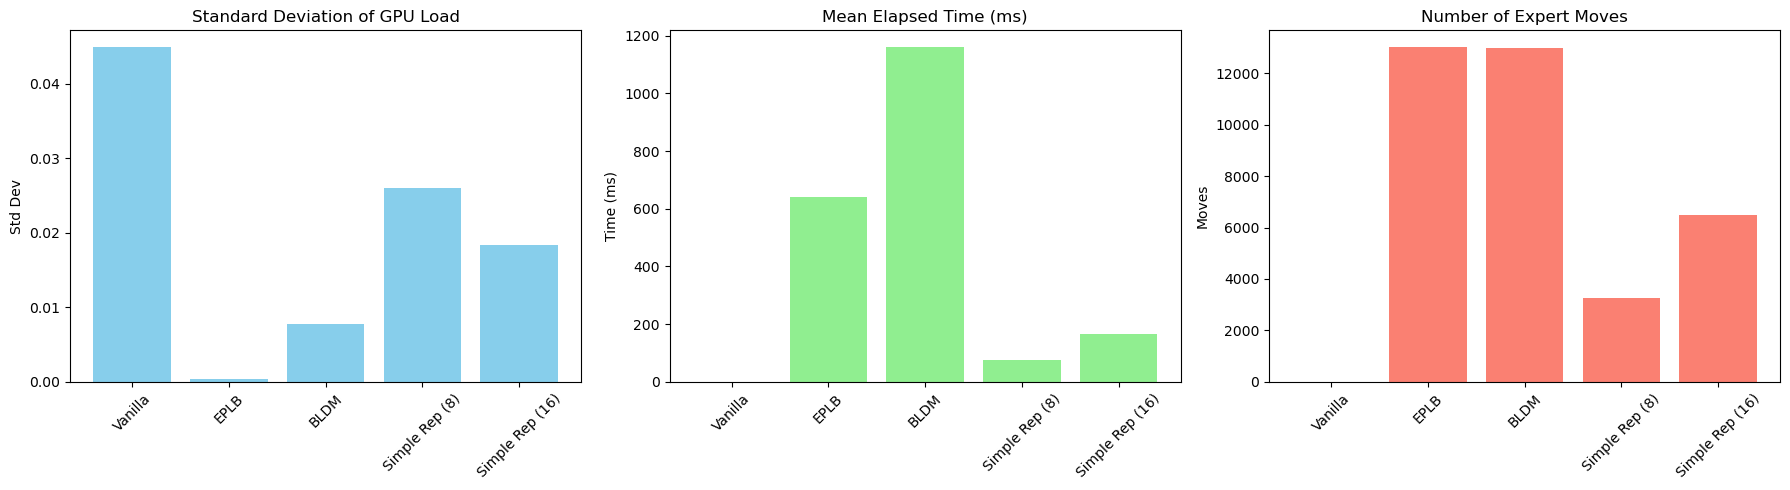

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# algorithm names
methods = ["Vanilla", "EPLB", "BLDM", "Simple Rep (8)", "Simple Rep (16)"]

# std. devs of GPU load
std_devs = [0.0449, 0.0003, 0.0078, 0.0260, 0.0184]

# execution time(ms)
elapsed_times = [None, 641.48, 1160.89, 77.01, 166.48]

# Expert moves
expert_moves = [None, 13026, 12971, 3248, 6496]

elapsed_times_cleaned = [et if et is not None else 0 for et in elapsed_times]
expert_moves_cleaned = [em if em is not None else 0 for em in expert_moves]

x = np.arange(len(methods))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

x = np.arange(len(methods))

# gpu load std. dev. plot
axs[0].bar(x, std_devs, color="skyblue")
axs[0].set_title("Standard Deviation of GPU Load")
axs[0].set_ylabel("Std Dev")
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods, rotation=45)

# execution time plot
axs[1].bar(x, elapsed_times_cleaned, color="lightgreen")
axs[1].set_title("Mean Elapsed Time (ms)")
axs[1].set_ylabel("Time (ms)")
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods, rotation=45)

# expert moves plot
axs[2].bar(x, expert_moves_cleaned, color="salmon")
axs[2].set_title("Number of Expert Moves")
axs[2].set_ylabel("Moves")
axs[2].set_xticks(x)
axs[2].set_xticklabels(methods, rotation=45)

plt.tight_layout()
plt.show()